Calcul la variation du coef de silhouette et le nombre d'activé ou non quand le ratio pris autour de l'activé change

Temps environ: 10*15min

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

In [2]:
#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 0

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)


#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

setGPU: Setting GPU to: 0


Using TensorFlow backend.


In [3]:
#!pip install -q sklearn
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import operator 
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [ ]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

# CLUSTERING

In [ ]:
# we suppose k = 2 (activé and inactivé)

def AverageDistance(vecteur,vecteurs_without_vecteur):
    nCluster_i = len(vecteurs_without_vecteur)
    distance = 0
    for vect in vecteurs_without_vecteur:
        #distance = distance + scipy.spatial.distance.euclidean(vecteur,vect)
        distance = distance + numpy.linalg.norm(vecteur-vect)
    a = (1/(nCluster_i))*distance
    return a

def AverageDissimilarity(vecteur, vecteurs_from_another_cluster):
    nCluster_j = len(vecteurs_from_another_cluster)
    distance = 0
    for vect in vecteurs_from_another_cluster:
        #distance = distance + scipy.spatial.distance.euclidean(vecteur,vect)
        distance = distance + numpy.linalg.norm(vecteur-vect)
    b = (1/nCluster_j)*distance
    return b

def Silhouette(vecteurs, a, b):
    s = (b-a)/(max(a,b))
    return s

# quid si pas assez de partité ?
def SilhouetteScore(vecteurs_0,vecteurs_1):
    if len(vecteurs_0) == None or len(vecteurs_1) == None or len(vecteurs_0) == 0 or len(vecteurs_1) == 0:
        print('Error: all entries actived or not: Probably a pathologique neuron')
        return -2
    
    SilhouetteScoreSum = 0
    
    if len(vecteurs_0) < 3 :
        SilhouetteScoreSum = SilhouetteScoreSum + 1 #0
    else:
        for i in range(len(vecteurs_0)):
            a = AverageDistance(vecteurs_0[i], vecteurs_0[0:i]+vecteurs_0[(i+1):])
            b = AverageDissimilarity(vecteurs_0[i], vecteurs_1)
            s = Silhouette(vecteurs_0, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s
    
    if len(vecteurs_1) < 2 :
        SilhouetteScoreSum = SilhouetteScoreSum + 1 #0
    else:
        for i in range(len(vecteurs_1)):
            a = AverageDistance(vecteurs_1[i], vecteurs_1[0:i]+vecteurs_1[(i+1):])
            b = AverageDissimilarity(vecteurs_1[i], vecteurs_0)
            s = Silhouette(vecteurs_1, a, b)
            SilhouetteScoreSum = SilhouetteScoreSum + s

    SilhouetteScore = SilhouetteScoreSum/(len(vecteurs_0)+len(vecteurs_1))
        
    return SilhouetteScore

In [ ]:
def TakeTheNearest(Vector, Ratio, Dist):
    Length = len(Vector)
    DistVector = []
    if Dist == 'cosine':
        for i in range(len(Vector)):
            Dist = 0
            for j in range(len(Vector)):
                if i!=j:
                    Dist = Dist + scipy.spatial.distance.cosine(Vector[i],Vector[j])
            DistVector.append(Dist)
    elif Dist == 'euclidean':
        for i in range(len(Vector)):
            Dist = 0
            for j in range(len(Vector)):
                if i!=j:
                    Dist = Dist + scipy.spatial.distance.euclidean(Vector[i],Vector[j])
            DistVector.append(Dist)
    else:
        print("ERROR in the Distance specification")
    #print(len(Vector[0])) # nombre de dimension des activations
    #print(len(DistVector)) # nombre d'activations activé ou non-activé
    
    UltimeVector = zip(DistVector, Vector)
    UltimeVectorList = list(UltimeVector)
    #print(UltimeVectorList)
    #print(UltimeVectorList[0][0]) # 1ere distance totale
    #print(UltimeVectorList[0][1]) # coordonnées de la premiere activation
    #print(UltimeVectorList[:][1]) # toutes les coordonnées
    UltimeVectorList.sort(key=operator.itemgetter(0))
    #print(UltimeVectorList)
    #print(UltimeVectorList[0][0]) # distance 0
    #print(UltimeVectorList[0][1]) # coord 0
    #print(UltimeVectorList[1][0]) # dist 1
    
    Vec = [lis[1] for lis in UltimeVectorList]
    NewVector = Vec[:int(np.floor(Length*Ratio))]
    return NewVector

In [ ]:
def CheckTheNearests(point, Vecteur, Label, Ratio, Dist):
    point = numpy.asarray([point])
    Vecteur = numpy.asarray(Vecteur)
    Length = len(Vecteur)
    Distances = scipy.spatial.distance.cdist(point, Vecteur, metric=Dist) #return a matrix
    
    UltimeVector = zip(Distances[0], Vecteur, Label)
    UltimeVectorList = list(UltimeVector)
    UltimeVectorList.sort(key=operator.itemgetter(0))
    Vec = [lis[1] for lis in UltimeVectorList]
    Vect = Vec[:int(np.floor(Length*Ratio))]
    Vec = [lis[2] for lis in UltimeVectorList]
    Lab = Vec[:int(np.floor(Length*Ratio))]

    return Vect, Lab

In [ ]:
def RUN2(IM, modelename, Dist, couchenumber):
    #Layer to test
    couche_name_A = 'conv2d_{}/BiasAdd:0'.format(couchenumber)
    couche_name_B = 'activation_{}/Relu:0'.format(couchenumber)

    X_Kernel_size = len(IM[couche_name_A][0,:,:,:])
    Y_Kernel_size = len(IM[couche_name_A][0,0,:,:])
    Z_Kernel_size = len(IM[couche_name_A][0,0,0,:])

    #Choix du neurone dans la couche
    X = int(numpy.ceil(numpy.random.rand(1)*X_Kernel_size)-1)
    Y = int(numpy.ceil(numpy.random.rand(1)*Y_Kernel_size)-1)
    Z = int(numpy.ceil(numpy.random.rand(1)*Z_Kernel_size)-1)
    #specification de ses bornes
    X_inf = X-1
    Y_inf = Y-1
    X_sup = X+1
    Y_sup = Y+1
    if X == 0: X_inf = 0
    if Y == 0: Y_inf = 0   
    if X == X_Kernel_size-1: X_sup = X_Kernel_size-1
    if Y == Y_Kernel_size-1: Y_sup = Y_Kernel_size-1

    Vecteurs_1 = [] #elements activés
    Vecteurs_All = [] #tous
    Labels_All = [] #leur label
    
    nombreDImagesDActivation = len(IM['conv2d_1/BiasAdd:0'][:])
    for j in range(nombreDImagesDActivation):
        if IM[couche_name_B][j,X,Y,Z] == 0.0:
            Vecteurs_All.append(IM[couche_name_A][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
            Labels_All.append(0)
        elif IM[couche_name_B][j,X,Y,Z] > 0.0:
            Vecteurs_1.append(IM[couche_name_A][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
            Vecteurs_All.append(IM[couche_name_A][j,X_inf:X_sup,Y_inf:Y_sup,0:Z_Kernel_size].flatten())
            Labels_All.append(1)
            
    ratio1=0.2
    Vecteurs_1_nearest = TakeTheNearest(Vecteurs_1, ratio1, Dist)
    
    SC_by_Ratio = []
                
    #pour chaque element de Vecteurs_1_nearest
    Length_Vecteurs_1_nearest = len(Vecteurs_1_nearest)
    print('   Number of {} ration nearest activated element :'.format(ratio1)+str(Length_Vecteurs_1_nearest))
    Ratios = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.3, 0.5]
    if Length_Vecteurs_1_nearest != 0:
        SC_by_Ratio = []
        for ratio in Ratios:
            SC = []
            for activé in range(Length_Vecteurs_1_nearest):
                Vect, Lab = CheckTheNearests(Vecteurs_1_nearest[activé], Vecteurs_All, Labels_All, ratio, Dist)
                #assert if there are strictly more than 1 label
                if len(set(Lab)) >1 and len(Vect)>2:
                    SC.append(sklearn.metrics.silhouette_score(Vect, Lab, metric=Dist))
            
            SC_by_Ratio.append(np.mean(SC))
        return SC_by_Ratio
    else:
        print('Erreur: pas d\'éléments activés')
        
    return 'To ignore'

In [ ]:
def RUN(IM, modelename, Dist, couchenumber):
    
    SC_by_Ratio = []
    NumberOfTest = 20
    for i in range(NumberOfTest):
        ret = RUN2(IM, modelename, Dist, couchenumber)
        if ret != 'To ignore':
            SC_by_Ratio.append(ret)
    
    SC_by_Ratio_Mean = np.nanmean(SC_by_Ratio, axis=0)
    
    #plot:
    plt.rcParams.update({'font.size': 20})
    Ratios = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.3, 0.5]
    fig = plt.figure(figsize=(10, 5))
    plt.ylim(top=1)
    plt.xlim(right=0.5, left=0)
    plt.plot(Ratios, SC_by_Ratio_Mean)
    #plt.xlabel('Ratio')
    #plt.ylabel('SC ratio-around activated elements')
    plt.grid()
    plt.show()
    fig.savefig('figures/SilhouetteCoef_Weighted/RatioAround/RatioAroundMean{}_{}_2000imAct_couche{}_{}.png'.format(NumberOfTest, modelename, couchenumber, Dist), dpi=100) 
            

In [ ]:
 #couchenumbermax=13
CoucheToTest = 7
Dist = 'cosine'

   Number of 0.2 ration nearest activated element :237


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :0
Erreur: pas d'éléments activés
   Number of 0.2 ration nearest activated element :323


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :89


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :3


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :387


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :0
Erreur: pas d'éléments activés
   Number of 0.2 ration nearest activated element :361


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :400


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :141
   Number of 0.2 ration nearest activated element :33


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :400


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :229
   Number of 0.2 ration nearest activated element :65


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :246


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :159


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :97


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :117


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :393


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :3


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/linux/mnovak/penv/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


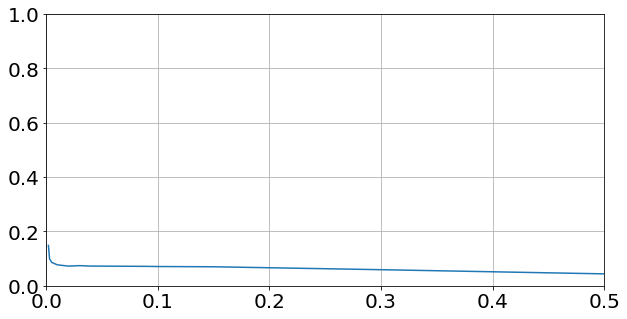

In [ ]:
# LOAD the model and get the activations
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/initial/weights-initial.hdf5'.format(modelename) #final / initial ! attention au nom de sauvegarde !
modelename = 'initial'
model = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)
model.load_weights('{}'.format(model_name))
sgd = optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
Echantillon = []
nombreDImagesDActivation = 2000
choix = np.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]
IM = get_activations(model, Echantillon)# on affiche les noms des differentes couches

#Run the code:
RUN(IM, modelename, Dist, CoucheToTest)

   Number of 0.2 ration nearest activated element :345


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :169


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :393


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :240


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :249


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :169


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :199


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :159


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :255


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :137


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :231


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :256


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :160


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :166


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :86


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :57


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :385


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :269


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :201


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :243


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/linux/mnovak/penv/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


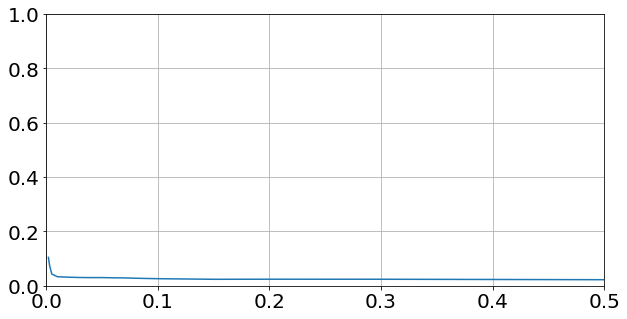

In [ ]:
modelename = 'vgg16_layca_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_layca_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

   Number of 0.2 ration nearest activated element :206


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :267


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :224


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :338


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :213


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :345


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :141


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   Number of 0.2 ration nearest activated element :241


/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/linux/mnovak/penv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
modelename = 'vgg16_layca_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_sgd_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_sgd_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_sgd_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_wdecay_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)

In [ ]:
modelename = 'vgg16_wdecay_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
RUN(IM, modelename, Dist, CoucheToTest)